<span style="font-size:110%; text-align:left;"><b><a href="../index.html">1. Introduction</a> > <a href="./index.html">1. Getting Started</a></b></span>
<br/><br/>
<span style="font-size:200%; text-align:left;"><b>Pykat</b></span>
<br/><br/>
<span style="font-size:110%; text-align:left;">Author: Daniel Brown </span>

# Table of Contents
 <p><div class="lev1"><a href="#1.-Introduction">1. Introduction</a></div><div class="lev1"><a href="#2.-Workflow---Creating-the-model-and-simulation">2. Workflow - Creating the model and simulation</a></div><div class="lev2"><a href="#2.1.-The-kat-object">2.1. The kat object</a></div><div class="lev2"><a href="#2.2.-What-is-in-our-kat-object?">2.2. What is in our <code>kat</code>-object?</a></div><div class="lev2"><a href="#2.3.-Interacting-with-components/detectors/commands">2.3. Interacting with components/detectors/commands</a></div><div class="lev2"><a href="#2.4.-What-is-the-final-Finesse-file-that-is-run?">2.4. What is the final Finesse file that is run?</a></div><div class="lev2"><a href="#2.5.-Run-the-simulation-and-access-the-output">2.5. Run the simulation and access the output</a></div><div class="lev2"><a href="#2.6.-Multiple-simulations-on-the-same-model">2.6. Multiple simulations on the same model</a></div><div class="lev1"><a href="#3.-Conclusion">3. Conclusion</a></div>

In [21]:
import pykat
%matplotlib inline

# 1. Introduction

This section aims to outline both the philosophy of Pykat and provide an overview of how it intends to work.

Pykat is an object-orientated Python wrapper for the Finesse binary. It aims to simplify the usage of Finesse for more complex simulation tasks. For example:
* Optimisation problems
* Chained simulations, feeding results of one simulation into the next
* Advanced plotting of outputs
* Automation of simulations
* Running simulations on clusters
* Using IPython/Jupyter notebooks to document simulation tasks

Interacting with Finesse to run more complicated simulation tasks using just the builtin plotting and output functionality quickly becomes limiting. In such cases it is usual to want to loop, repeat or modify simulations as you experiment and better understand the problem. Pykat has evolved to make such tasks easier.

There are three distinct features in the Pykat-Finesse interaction that will be referred to throughout this description:
* The **Model**: A particular optical setup or layout that 
* The **Simulation**: When a Finesse model is run to generate a particular output
* The **Output**: The data generated by a particular simulation

The **model** of the interferometer is that which you design and generate using Finesse commands. This will be a collection of optical components that represents the system in general. It does not assume anything about what data will be produced or detectors used.

Once a model is created you can design the type of **Simulation** that you wish to run. This requires you to first decide what type of output you want to see, thus what detectors you need to add to extract optical, mechanical or other values. Along with this the changing variable must also be set using the xaxis setting.

Finally, a simulation is taken and you **run** it. This takes all the settings and configuration of the simulations and passes it to the Finesse binary. This then runs the simulation and generates various data files containing the **output** result. Pykat parses these data files into more friendly formats for the user to enable plotting or further processing of the output.

<img src="files/pykat_outline.svg" style="width: 850px;"/>

# 2. Workflow - Creating the model and simulation

It is important when using Pykat, Python and Finesse to have a structured workflow and a proper understanding of what each of these elements do. By doing this you should be able to keep your scripts clean and usable.

## 2.1. The kat object

Firstly, the most important object of pykat is the `kat` object. The name `kat` was chosen as this is the name of the Finesse binary. 

This object contains all the model details and describes one simulation. Thus, it is worthwhile to perceive this `kat` object as a single Finesse file that you might write by hand - except that this object handles the writing, running and processing of the output of the final file for you. By interacting with this object and its contents you alter the Finesse file that will be run.

You can build your model and setup your simulation in two ways: By entering the standard Finesse commands (either as strings or by loading a pre-written Finesse file) or by creating directly creating pykat objects. We will concentrate on the first option here.

We start by creating an empty model like so:

In [22]:
kat = pykat.finesse.kat()

In its current state this kat object doesn't do anything. You can load an existing Finesse file, if you have one, into the object with:

In [23]:
kat.loadKatFile("cavity.kat")

Here a simple file consisting of a laser and a Fabry-Perot cavity has been added. You'll notice that no output is shown here. If there is an error in parsing any of the commands in a file these will show up at this stage.

This Finesse file contains a model of a Fabry-Perot cavity and the commands to simulate a scanning one of the mirrors to output the circulating power in it.

## 2.2. What is in our `kat`-object?

For (nearly) every Finesse component, detector and command there is an equivalent Pykat object. When a Finesse file is read each line will be parsed for the type of object and its parameters to load into the `kat` object. For example, a laser is described by the object `pykat.components.pykat.components.laser`.

There are three main dictionaries that store the three different types of Finesse objects: components, detectors and commands. The key to dictionary is the name of the component, detector or command and the value is the object itself. You can see the contents by printing them:

In [24]:
print(kat.components)
print(kat.detectors)
print(kat.commands)

{'m2': <pykat.components.pykat.components.mirror_44 object at 0x11089a160>, 'l1': <pykat.components.pykat.components.laser_41 object at 0x1103b86a0>, 'm1': <pykat.components.pykat.components.mirror_42 object at 0x1108904e0>, 's1': <pykat.components.pykat.components.space_43 object at 0x110890278>}
{'circ': <pykat.detectors.pykat.detectors.pd_6 object at 0x1103cab00>}
{'xaxis': <pykat.commands.xaxis object at 0x1109b7ac8>}


We can see here we have a laser called `l1`, mirrors `m1` and `m2`, a space `s1`, a single `pd` (DC photodiode) detector `circ` and an `xaxis` command.

**IMPORTANT NOTE: ** Do not add/remove/change the dictionary enteries yourself!! Doing this will break various internal connections and will just stop it working.

If you want to get hold of a particular object you can do it in two ways:

In [25]:
kat.components["m1"]

In [26]:
kat.m1

Note that the object reference, something like `0x10771bd30`, is the same in both cases. So we can see we are accessing the same object.

The second method is the recommended way when writing your scripts and know the name of the object, as this is less typing. It also allows for auto-complete to work on the object. So when typing code you can type `kat.m1.` then press the tab key to see all the possible parameters.

The first method though is still useful in cases where you need to access objects when you have the name in a string. A typical example might be looping over objects by their name:

In [27]:
for n in range(1,3):
    m = kat.components["m"+str(n)]
    print(repr(m)) # Here we print the object info

## 2.3. Interacting with components/detectors/commands

Once the objects have been added to the `kat` object we can change their parameters easily. For example, we can change the reflectivity and transmistivity of the input mirror with:

In [28]:
kat.m1.R = 0.6
kat.m1.T = 0.4

Likewise, we can quickly see what the value of particular parameters is:

In [29]:
print(kat.m1.R)

0.6


If using Pykat, or IPython, then you have access to auto-complete features on objects. This is paritcularly handy for exploring Pykat objects and their properties. You can easily see the options available by typing `.` after the object and pressing the tab key. For exmaple:

<img style="display:inline-block; padding-top:13px;" align="left" src="intellisense.png">
<img style="display:inline-block;" align="left" src="intellisense2.png">

## 2.4. What is the final Finesse file that is run?

Pykat is just a set of tools that produces a complete Finesse file and then runs it. It is sometimes useful to be able to print the actual Finesse file that is run to double check you have the correct file or to better understand some result you were not expecting.

To do this we just print the `kat` object we are interested in:

In [30]:
print(kat)

kat.s1.L = 10

print(kat)

% Generated by PyKat 29.04.2016 14:27:30

l l1 1.0 0.0 0.0 n0
m m1 0.6 0.4 0.0 n0 n1
s s1 1.0 n1 n2
m m2 0.5 0.5 0.0 n2 n3
xaxis m2 phi lin 0 180 180
pd0 circ n1
yaxis abs

% Generated by PyKat 29.04.2016 14:27:30

l l1 1.0 0.0 0.0 n0
m m1 0.6 0.4 0.0 n0 n1
s s1 10.0 n1 n2
m m2 0.5 0.5 0.0 n2 n3
xaxis m2 phi lin 0 180 180
pd0 circ n1
yaxis abs



Here we can see all the components, detectors and commands for simulating the cavity scan to output the circulating power. Then when we change some parameter we can also see how the length of the space `s1` changes.

## 2.5. Run the simulation and access the output

Running the simulation is straight forward:

In [31]:
out = kat.run()

--------------------------------------------------------------
Running kat - Started at 2016-04-29 14:27:30.564379

Finished in 0.210479 seconds


100% | ETA:  0:00:00 | Saving data                                             

If all has worked then it will just print how long it took to run. The `out` object contains the output of the simulation. The output will consist of arrays for each of the detectors you include in your simulation.

The detector output is accessed via its name with the output object:

In [32]:
print(out["circ"])

[ 1.9554654   1.94910687  1.93028455  1.89973351  1.85860062  1.8083415
  1.75060076  1.68709253  1.61949502  1.54936799  1.47809659  1.40686068
  1.33662548  1.26814858  1.20199758  1.13857382  1.07813847  1.02083827
  0.96672932  0.91579815  0.86797954  0.82317123  0.78124583  0.74206012
  0.70546221  0.67129699  0.63941006  0.6096506   0.58187331  0.55593967
  0.53171872  0.50908742  0.48793075  0.4681416   0.44962056  0.43227555
  0.41602147  0.40077976  0.38647797  0.37304936  0.36043246  0.34857066
  0.33741185  0.32690806  0.31701511  0.30769231  0.29890217  0.29061016
  0.2827844   0.27539551  0.26841637  0.26182194  0.25558907  0.24969637
  0.24412406  0.23885384  0.23386876  0.22915313  0.2246924   0.2204731
  0.21648272  0.21270967  0.2091432   0.20577333  0.2025908   0.199587
  0.19675397  0.1940843   0.19157113  0.1892081   0.18698932  0.18490932
  0.18296306  0.18114587  0.17945346  0.17788187  0.17642747  0.17508692
  0.17385719  0.17273551  0.17171939  0.17080658  0.169

The output object contains a variety of information about the simulation. A summary of the data it contains can be found with:

In [33]:
out.info()


--- Output info ---

Run date and time: 2016-04-29 14:27:30.564517
Detectors used: circ

One xaxis used: xaxis m2 phi lin 0 180 180
circ : min = 1.669835795834020e-01 max = 1.955465400008440e+00


Or we can see what Finesse commands were used to generate this data:

In [34]:
print(out.katScript)

% Generated by PyKat 29.04.2016 14:27:30

l l1 1.0 0.0 0.0 n0
m m1 0.6 0.4 0.0 n0 n1
s s1 10.0 n1 n2
m m2 0.5 0.5 0.0 n2 n3
xaxis m2 phi lin 0 180 180
pd0 circ n1
yaxis abs
time
gnuterm no
pyterm no



Or you can quickly get the xaxis values and make a plot of your choosing:

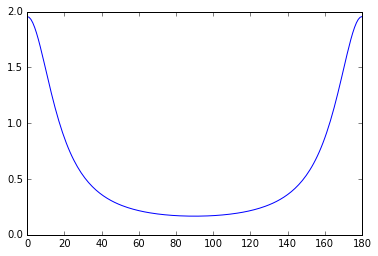

In [35]:
import pylab
pylab.plot(out.x, out["circ"])

Or if you want something quick you can quickly use the builtin plotting (More example of which can be found in the plotting example notebook):

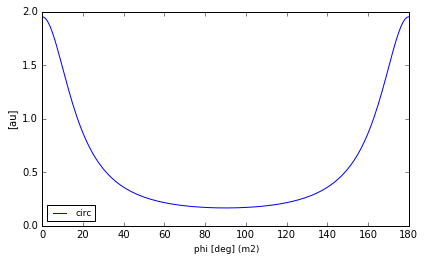

In [36]:
fig = out.plot()

## 2.6. Multiple simulations on the same model

A common requirement for more complicated simulations is the ability to change something in the model and re-run the simulation. Typically this requires various xaxis commands and detector combintions to get the output you desire. The way this would be done in Finesse would be if you had separate Finesse files for each of the simulations you wanted to run. Or you could have one big file and comment/uncomment particular lines - either of these become troublesome for complicated changes.

In Pykat we deal with objects. The recommended workflow is if you keep a single `.kat` file that contains you base model, or commands that will be common to the majority of your simulations. From this base model you then copy it within Pykat and then add in the simulation specific commands you require. For example:

In [37]:
basekat = pykat.finesse.kat()
basekat.loadKatFile("cavity_base.kat")

kat1 = basekat.deepcopy()
kat1.parseCommands("""
# Finese code for this one type of simulation ...
""")

kat2 = basekat.deepcopy()
kat2.parseCommands("""
# Finese code for this another type of simulation ...
""")

# Then run it:      out1 = kat1.run()
# And the next one: out2 = kat2.run()

With these copies we can do whatever we like, add and remove new optical components, change parameters, etc.. You just need to be careful that you keep track of which `kat` object has what changes.

This will be a common pattern used throughout these series of notebooks. Another useful pattern is when making function that accept a `kat` object. For example, we might want to make a function that simulates the power in a cavity when the mirror is tuned. This function will take the model, the mirror to move and which node to get the power from, compute the result and return the values. This however, will not alter the original `kat` object, so we can continue using it for something else.

In [38]:
def simulate_intracavity_power(kat_in, mirror, node):
    kat = kat_in.deepcopy()
    kat.parseCommands("""
    xaxis {mirror} phi lin 0 180 180
    pd circ {node}
    """.format(mirror = mirror,
               node = node))
    
    out = kat.run()
    
    return out["circ"]


basekat = pykat.finesse.kat()
basekat.loadKatFile("cavity_base.kat")

simulate_intracavity_power(basekat, "m2", "n2")

--------------------------------------------------------------
Running kat - Started at 2016-04-29 14:27:31.430095

Finished in 0.167374 seconds


100% | ETA:  0:00:00 | Saving data                                             

array([ 1.        ,  0.99756923,  0.99035023,  0.97855744,  0.96253086,
        0.94271233,  0.91961668,  0.89380114,  0.86583594,  0.83627847,
        0.80565277,  0.77443462,  0.74304243,  0.71183304,  0.68110165,
        0.65108474,  0.62196496,  0.59387723,  0.56691527,  0.54113814,
        0.51657636,  0.49323754,  0.47111127,  0.45017335,  0.43038935,
        0.41171755,  0.39411133,  0.37752104,  0.36189553,  0.34718329,
        0.33333333,  0.32029583,  0.30802256,  0.29646729,  0.28558588,
        0.2753365 ,  0.26567961,  0.25657798,  0.24799666,  0.23990289,
        0.23226606,  0.22505757,  0.21825073,  0.21182069,  0.2057443 ,
        0.2       ,  0.19456775,  0.18942889,  0.18456607,  0.17996317,
        0.17560518,  0.17147815,  0.16756909,  0.16386594,  0.16035746,
        0.15703319,  0.15388341,  0.15089906,  0.14807171,  0.14539351,
        0.14285714,  0.14045581,  0.13818316,  0.1360333 ,  0.13400073,
        0.13208032,  0.13026732,  0.12855728,  0.1269461 ,  0.12

# 3. Conclusion

This notebook has introduced the basics of Pykat and some recommended workflows. Obviously, you are free to try out other methods, but those shown above in our experience have been the most useful. 

It is important to remember with Pykat that it is just a Finesse file generator. To use Pykat effectively you still need to understand the underlying principles behind Finesse and how to generate these files yourself. If you don't have this experience then you are likely to end up confused when things do not run as expected!